In [80]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
folder = '.'+os.sep+"data"+os.sep+"options/"
filenames = [name for name in os.listdir(folder) if not os.path.isdir(folder+name)]

df_local_ohlc=pd.DataFrame()
df_symbol = dict()
dfs = []
for f in filenames:
    df = pd.read_hdf(f"{folder}{f}", key="options", mode="r")
    df["Date"] = datetime.strptime(f.split(".")[0], "%Y-%m-%d")
    df["strike"] = df["strike"].astype(float)
    df["implied_volatility"] = df["implied_volatility"].astype(float)
    df["volume"] = df["volume"].astype(int)
    df["open_interest"] = df["open_interest"].astype(int)
    dfs.append(df)
df_total_ohlc = pd.concat(dfs, axis=0)

In [81]:
import yfinance as yf
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

symbol = "TSLA"
df_symbol = df_total_ohlc.loc[df_total_ohlc["underlying_symbol"] == symbol]
def sum_all_volume(df_sub):
    return pd.Series(
        {
            "volume": df_sub["volume"].sum(),
            "open_interest": df_sub["open_interest"].sum(),
            "IV_VolWeighted": (
                df_sub["implied_volatility"] * df_sub["volume"]
            ).sum() / df_sub["volume"].sum(),
            "IV_OIWeighted": (
                df_sub["implied_volatility"] * df_sub["open_interest"]
            ).sum() / df_sub["open_interest"].sum(),
        },
    )

df = df_symbol.groupby(["Date", "option_type"]).apply(sum_all_volume)
start_date = df.index.get_level_values("Date").min()
end_date = df.index.get_level_values("Date").max() + timedelta(days=1)


# Download historical price data
price_data = yf.download(symbol, start=start_date, end=end_date)
price_data = price_data[["Close"]].reset_index()
df = df.reset_index().merge(price_data, left_on="Date", right_on="Date", how="left")
df = df.set_index(["Date", "option_type"])

df_unstacked = df.unstack(level="option_type")
df_unstacked["volume_ratio"] = (
    df_unstacked["volume"]["call"] / df_unstacked["volume"]["put"]
)
df_unstacked["open_interest_ratio"] = (
    df_unstacked["open_interest"]["call"] / df_unstacked["open_interest"]["put"]
)
df_unstacked["IV_Volume"] = (
    df_unstacked["IV_VolWeighted"]["call"] * df_unstacked["volume"]["call"]
    + df_unstacked["IV_VolWeighted"]["put"] * df_unstacked["volume"]["put"]
) / (df_unstacked["volume"]["call"] + df_unstacked["volume"]["put"])

df_unstacked["IV_OI"] = (
    df_unstacked["IV_OIWeighted"]["call"] * df_unstacked["open_interest"]["call"]
    + df_unstacked["IV_OIWeighted"]["put"] * df_unstacked["open_interest"]["put"]
) / (df_unstacked["open_interest"]["call"] + df_unstacked["open_interest"]["put"])

import plotly.express as px
import plotly.graph_objects as go


# Create subplots with shared x-axis
fig = make_subplots(
    rows=2,
    cols=1,  # 2 rows, 1 column
    shared_xaxes=True,  # Share the x-axis
    vertical_spacing=0,  # Space between subplots
    subplot_titles=(
        f"{symbol} Volume, Open Interest, and Close Price",
        "Call/Put Ratios and IV Metrics",
    ),  # Titles for each subplot
    specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
)

# Add traces for the original 4 lines to the first subplot (row=1, col=1)
fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["volume"]["call"],
        mode="lines",
        name="Volume (Call)",
        line=dict(color="blue", dash="solid"),
        hovertemplate="Date: %{x}<br>Volume (Call): %{y}<extra></extra>",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["volume"]["put"],
        mode="lines",
        name="Volume (Put)",
        line=dict(color="blue", dash="dash"),
        hovertemplate="Date: %{x}<br>Volume (Put): %{y}<extra></extra>",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["open_interest"]["call"],
        mode="lines",
        name="Open Interest (Call)",
        line=dict(color="green", dash="solid"),
        hovertemplate="Date: %{x}<br>Open Interest (Call): %{y}<extra></extra>",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["open_interest"]["put"],
        mode="lines",
        name="Open Interest (Put)",
        line=dict(color="green", dash="dash"),
        hovertemplate="Date: %{x}<br>Open Interest (Put): %{y}<extra></extra>",
    ),
    row=1,
    col=1,
)

# Add trace for the Close price to the first subplot (row=1, col=1) on the secondary y-axis
fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["Close"]["call"],
        mode="lines",
        name="Close Price",
        line=dict(color="red", dash="solid"),
        hovertemplate="Date: %{x}<br>Close Price: %{y}<extra></extra>",
    ),
    row=1,
    col=1,
    secondary_y=True,
)  # Use secondary y-axis

# Add traces for the Call/Put Ratios to the second subplot (row=2, col=1)
fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["volume_ratio"],
        mode="lines",
        name="Volume Call/Put Ratio",
        line=dict(color="red", dash="dot"),
        hovertemplate="Date: %{x}<br>Volume Call/Put Ratio: %{y}<extra></extra>",
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["open_interest_ratio"],
        mode="lines",
        name="Open Interest Call/Put Ratio",
        line=dict(color="purple", dash="dot"),
        hovertemplate="Date: %{x}<br>Open Interest Call/Put Ratio: %{y}<extra></extra>",
    ),
    row=2,
    col=1,
)

# Add traces for IV_Volume and IV_OI to the second subplot (row=2, col=1) on the secondary y-axis
fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["IV_Volume"],
        mode="lines",
        name="IV Volume",
        line=dict(color="orange", dash="solid"),
        hovertemplate="Date: %{x}<br>IV Volume: %{y}<extra></extra>",
    ),
    row=2,
    col=1,
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(
        x=df_unstacked.index,
        y=df_unstacked["IV_OI"],
        mode="lines",
        name="IV Open Interest",
        line=dict(color="brown", dash="solid"),
        hovertemplate="Date: %{x}<br>IV Open Interest: %{y}<extra></extra>",
    ),
    row=2,
    col=1,
    secondary_y=True,
)

# Update layout
fig.update_layout(
    title=f"{symbol} Volume, Open Interest, Close Price, and Call/Put Ratios with IV Metrics",
    hovermode="x unified",
    height=800,  # Adjust height for better visualization
)

# Update y-axis titles
fig.update_yaxes(title_text="Volume / Open Interest", row=1, col=1)
fig.update_yaxes(title_text="Close Price", row=1, col=1, secondary_y=True)
fig.update_yaxes(title_text="Call/Put Ratio", row=2, col=1)
fig.update_yaxes(title_text="IV Metrics", row=2, col=1, secondary_y=True)

# Remove gaps on weekends by treating x-axis as categorical
fig.update_xaxes(
    type="category",  # Treat x-axis as categorical (no gaps)
    tickvals=df_unstacked.index,  # Set tick marks to match data dates
    tickformat="%Y-%m-%d",  # Format dates
    row=1,
    col=1,
)
fig.update_xaxes(
    type="category",  # Treat x-axis as categorical (no gaps)
    tickvals=df_unstacked.index,  # Set tick marks to match data dates
    tickformat="%Y-%m-%d",  # Format dates
    row=2,
    col=1,
)

# Show the plot
fig.show()

C:\Users\hui\AppData\Local\Temp\ipykernel_22444\928958083.py:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

[*********************100%***********************]  1 of 1 completed


In [82]:
import yfinance as yf
from datetime import timedelta
import plotly.graph_objects as go
import pandas as pd

# Sample data preparation (replace with your actual data)
# df_total_ohlc = ...

# Filter data for the specific symbol
symbol = "NVDA"
df_symbol = df_total_ohlc.loc[df_total_ohlc["underlying_symbol"] == symbol]

# Function to sum volume and open interest
def sum_all_volume(df_sub):
    return pd.Series(
        {
            "volume": df_sub["volume"].sum(),
            "open_interest": df_sub["open_interest"].sum(),
        }
    )

# Aggregate data by Date and option_type
df = df_symbol.groupby(["Date", "option_type"]).apply(sum_all_volume)
start_date = df.index.get_level_values("Date").min()
end_date = df.index.get_level_values("Date").max() + timedelta(days=1)

# Download historical price data
price_data = yf.download(symbol, start=start_date, end=end_date)
price_data = price_data.reset_index()

# Merge with price data
df = df.reset_index().merge(price_data, left_on="Date", right_on="Date", how="left")
df = df.set_index(["Date", "option_type"])

# Unstack the DataFrame
df_unstacked = df.unstack(level="option_type")

# Calculate ratios
df_unstacked["volume_ratio"] = df_unstacked["volume"]["call"] / df_unstacked["volume"]["put"]
df_unstacked["open_interest_ratio"] = df_unstacked["open_interest"]["call"] / df_unstacked["open_interest"]["put"]

# Replace inf and NaN values in ratios with 0
df_unstacked["volume_ratio"].replace([float('inf'), float('-inf')], 0, inplace=True)
df_unstacked["open_interest_ratio"].replace([float('inf'), float('-inf')], 0, inplace=True)
df_unstacked["volume_ratio"].fillna(0, inplace=True)
df_unstacked["open_interest_ratio"].fillna(0, inplace=True)

# Create a single plot with simulated three y-axes
fig = go.Figure()

# Add Volume lines (left y-axis)
fig.add_trace(go.Scatter(x=df_unstacked.index, y=df_unstacked["volume"]["call"], mode="lines", name="Volume (Call)", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=df_unstacked.index, y=df_unstacked["volume"]["put"], mode="lines", name="Volume (Put)", line=dict(color="blue", dash="dash")))

# Add OHLC candlestick chart (right y-axis, primary)
fig.add_trace(
    go.Candlestick(
        x=df_unstacked.index,
        open=df_unstacked["Open"]["call"],
        high=df_unstacked["High"]["call"],
        low=df_unstacked["Low"]["call"],
        close=df_unstacked["Close"]["call"],
        name="OHLC Price",
        yaxis="y2",  # Assign to the secondary y-axis
    )
)

# Scale and offset Call/Put Ratios for the simulated third y-axis
scale_factor = 0.1  # Adjust this to fit the ratios within the chart
offset = df_unstacked["Close"]["call"].max()  # Offset to position ratios above OHLC

# Add Call/Put Ratios (right y-axis, secondary)
fig.add_trace(go.Scatter(x=df_unstacked.index, y=df_unstacked["volume_ratio"] * scale_factor + offset, mode="lines", name="Volume Call/Put Ratio", line=dict(color="red", dash="dot"), yaxis="y2"))
fig.add_trace(go.Scatter(x=df_unstacked.index, y=df_unstacked["open_interest_ratio"] * scale_factor + offset, mode="lines", name="Open Interest Call/Put Ratio", line=dict(color="purple", dash="dot"), yaxis="y2"))

# Layout updates
fig.update_layout(
    title="Volume, OHLC Price, and Call/Put Ratios",
    hovermode="x unified",
    height=800,
    showlegend=True,
    legend=dict(x=0.02, y=0.98),  # Adjust legend position
    yaxis=dict(title="Volume"),  # Left y-axis
    yaxis2=dict(title="OHLC Price & Call/Put Ratios", overlaying="y", side="right"),  # Right y-axis
)

# Add a dummy axis for the simulated third y-axis
fig.update_layout(
    annotations=[
        dict(
            text="Call/Put Ratios",
            x=1.1,  # Position outside the right y-axis
            y=0.5,
            xref="paper",
            yref="paper",
            showarrow=False,
            textangle=-90,
            font=dict(size=12),
        )
    ]
)

# Ensure x-axis alignment
fig.update_xaxes(
    type="date",
    tickformat="%Y-%m-%d",
)

fig.show()

C:\Users\hui\AppData\Local\Temp\ipykernel_22444\1500621223.py:23: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

[*********************100%***********************]  1 of 1 completed
C:\Users\hui\AppData\Local\Temp\ipykernel_22444\1500621223.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hui\AppData\Local\Temp\ipykernel_22444\1500621223.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [74]:
#df_1["implied_volatility"].plot(kind='line', linestyle='-', title="Option Values by Strike")
#df_2["implied_volatility"].plot(
#    kind="line", linestyle="-", title="Option Values by Strike"
#)
#df_3["implied_volatility"].plot(
#    kind="line", linestyle="-", title="Option Values by Strike"
#)

In [102]:
df_symbol

,underlying_symbol,underlying_price,contract_symbol,expiration,dte,strike,option_type,open_interest,volume,last_trade_price,last_trade_time,bid,ask,change,change_percent,implied_volatility,in_the_money,currency,Date
269404,NVDA,141.39,NVDA241101C00050000,2024-11-01,3,50.0,call,200,5,91.73,2024-10-29 15:51:04-04:00,90.9,92.45,0.38000488,0.0041598785,5.882815,True,USD,2024-10-29
269405,NVDA,141.39,NVDA241101P00050000,2024-11-01,3,50.0,put,826,4,0.01,2024-10-28 14:42:25-04:00,0.0,0.01,0.0,0.0,3.625001,False,USD,2024-10-29
269406,NVDA,141.39,NVDA241101C00055000,2024-11-01,3,55.0,call,213,8,85.57,2024-10-28 12:43:57-04:00,85.95,86.8,0.0,0.0,4.500004,True,USD,2024-10-29
269407,NVDA,141.39,NVDA241101P00055000,2024-11-01,3,55.0,put,210,2,0.01,2024-10-28 11:32:04-04:00,0.0,0.01,0.0,0.0,3.250002,False,USD,2024-10-29
269408,NVDA,141.39,NVDA241101C00060000,2024-11-01,3,60.0,call,4,1,80.84,2024-10-29 10:37:01-04:00,80.9,81.8,-0.29000092,-0.0035745215000000004,3.992188,True,USD,2024-10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116476,NVDA,138.5,NVDA270115P00280000,2027-01-15,700,280.0,put,60,2,147.53,2025-02-10 12:30:08-05:00,140.95,144.45,0.0,0.0,0.356879,True,USD,2025-02-14
116477,NVDA,138.5,NVDA270115C00290000,2027-01-15,700,290.0,call,12173,224,13.0,2025-02-14 15:51:21-05:00,12.7,13.05,1.0500002,0.087866125,0.548680,False,USD,2025-02-14
116478,NVDA,138.5,NVDA270115P00290000,2027-01-15,700,290.0,put,118,8,164.06,2025-02-06 10:51:52-05:00,150.5,153.85,0.0,0.0,0.352485,True,USD,2025-02-14
116479,NVDA,138.5,NVDA270115C00300000,2027-01-15,700,300.0,call,33915,524,12.0,2025-02-14 15:59:58-05:00,11.95,12.2,0.6999998,0.061946890000000004,0.549504,False,USD,2025-02-14


,underlying_symbol,underlying_price,contract_symbol,expiration,dte,strike,option_type,open_interest,volume,last_trade_price,last_trade_time,bid,ask,change,change_percent,implied_volatility,in_the_money,currency,Date
109004,NVDA,138.5,NVDA250221C00000500,2025-02-21,7,0.5,call,34662,14,137.3,2025-02-14 14:45:44-05:00,137.7,138.9,2.5400085,0.018848387,0.000000,True,USD,2025-02-14
109005,NVDA,138.5,NVDA250221P00000500,2025-02-21,7,0.5,put,3091,1,0.01,2025-02-07 10:43:23-05:00,0.0,0.01,0.0,0.0,14.000001,False,USD,2025-02-14
109006,NVDA,138.5,NVDA250221C00001000,2025-02-21,7,1.0,call,390,1,134.05,2025-02-13 14:22:16-05:00,137.3,138.6,0.0,0.0,16.875005,True,USD,2025-02-14
109007,NVDA,138.5,NVDA250221P00001000,2025-02-21,7,1.0,put,251,0,0.01,2025-01-27 09:44:50-05:00,0.0,0.01,0.0,0.0,11.750003,False,USD,2025-02-14
109008,NVDA,138.5,NVDA250221C00001500,2025-02-21,7,1.5,call,118,1,133.54,2025-02-13 14:22:16-05:00,136.5,137.85,0.0,0.0,20.906253,True,USD,2025-02-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116476,NVDA,138.5,NVDA270115P00280000,2027-01-15,700,280.0,put,60,2,147.53,2025-02-10 12:30:08-05:00,140.95,144.45,0.0,0.0,0.356879,True,USD,2025-02-14
116477,NVDA,138.5,NVDA270115C00290000,2027-01-15,700,290.0,call,12173,224,13.0,2025-02-14 15:51:21-05:00,12.7,13.05,1.0500002,0.087866125,0.548680,False,USD,2025-02-14
116478,NVDA,138.5,NVDA270115P00290000,2027-01-15,700,290.0,put,118,8,164.06,2025-02-06 10:51:52-05:00,150.5,153.85,0.0,0.0,0.352485,True,USD,2025-02-14
116479,NVDA,138.5,NVDA270115C00300000,2027-01-15,700,300.0,call,33915,524,12.0,2025-02-14 15:59:58-05:00,11.95,12.2,0.6999998,0.061946890000000004,0.549504,False,USD,2025-02-14


793125498
134098615


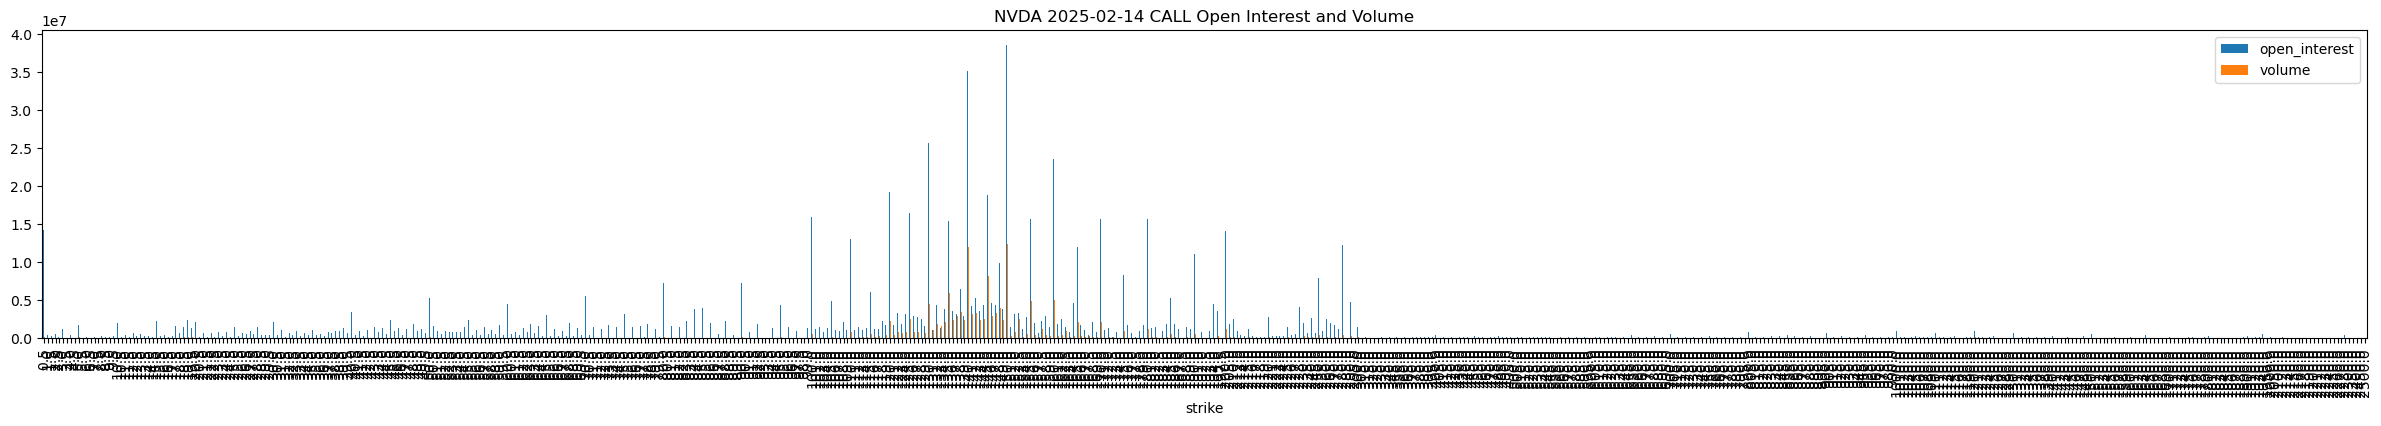

In [ ]:
latest_date = filenames[-1].split(".")[0]
df_ohlc_date = df_symbol.loc[df_symbol["Date"] == latest_date]
df_ohlc_date = df_ohlc_date[["expiration", "strike", "volume", "open_interest"]]
df_ohlc_date = df_ohlc_date.pivot_table(
    index="expiration", columns="strike", values="volume", aggfunc="sum"
).fillna(0)
df_call = (
    df_symbol.loc[(df_symbol["option_type"] == "call")]
    .reset_index()
    .set_index("strike")
)

df_call = df_call[["open_interest", "volume"]].groupby(level=0).sum()
df_call[["open_interest", "volume"]].groupby(level=0).sum().plot(
    kind="bar",
    figsize=(30, 4),
    title=f"{symbol} {latest_date} CALL Open Interest and Volume",
)
print (df_call["open_interest"].sum())
print(df_call["volume"].sum())

In [126]:
df

,expiration,strike,volume,open_interest
269404,2024-11-01,50.0,5,200
269406,2024-11-01,55.0,8,213
269408,2024-11-01,60.0,1,4
269410,2024-11-01,65.0,1,21
269412,2024-11-01,66.0,4,28
...,...,...,...,...
116471,2027-01-15,260.0,11,2570
116473,2027-01-15,270.0,4,2410
116475,2027-01-15,280.0,27,2300
116477,2027-01-15,290.0,224,12173


<Figure size 1000x600 with 0 Axes>

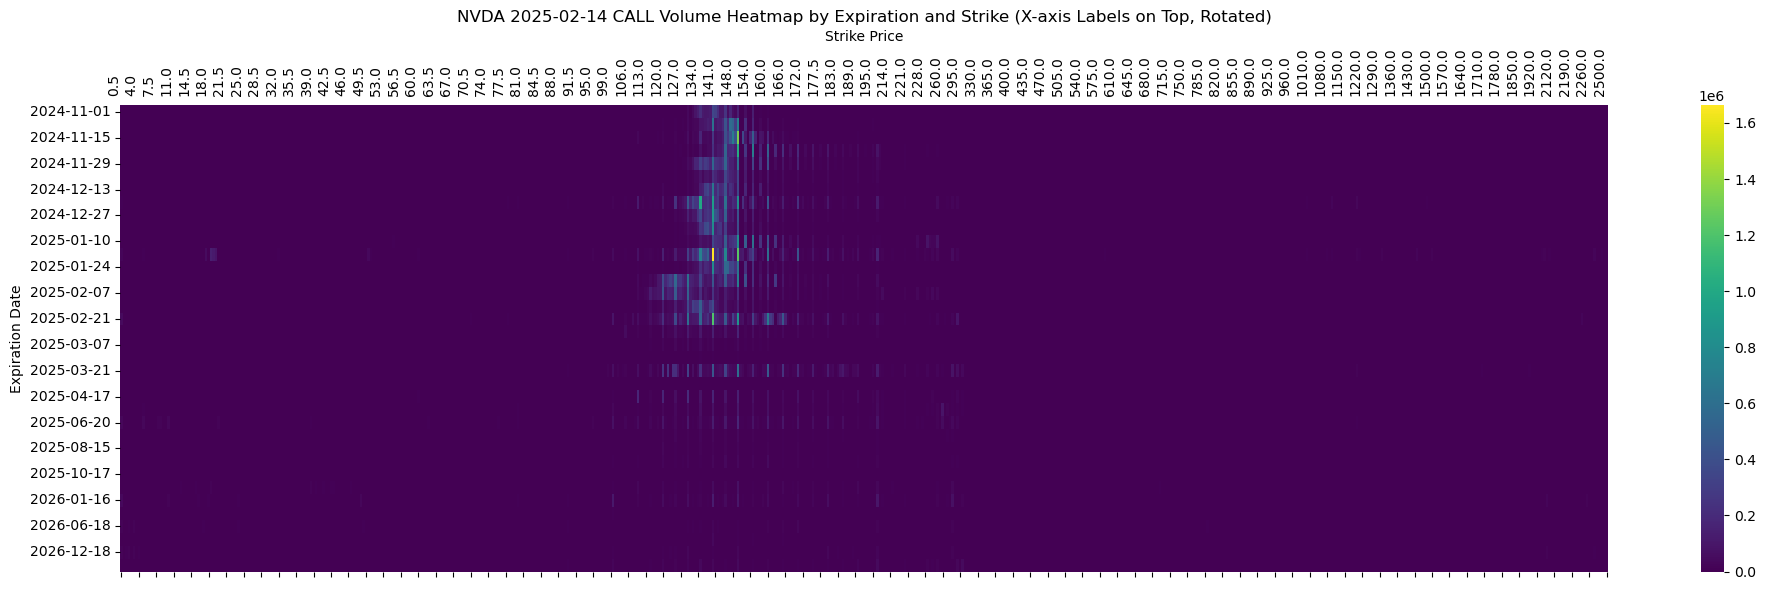

In [125]:
# Plotting the heatmap
df = df_symbol.loc[df_symbol['option_type']=='call'][["expiration", "strike", "volume", "open_interest"]]
plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    index="expiration", columns="strike", values="volume", aggfunc="sum"
).fillna(0)

# Plotting the heatmap without numbers
plt.figure(figsize=(20, 6))
ax = sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)

# Move x-axis labels to the top and rotate them
ax.tick_params(
    axis="x", which="both", labeltop=True, labelbottom=False
)  # Move labels to the top
plt.xticks(rotation=90, ha="right")  # Rotate labels and align them properly

# Optional: Move x-axis title to the top
ax.xaxis.set_label_position("top")
plt.xlabel("Strike Price")

# Customizing the plot
plt.title(
    f"{symbol} {latest_date} CALL Volume Heatmap by Expiration and Strike (X-axis Labels on Top, Rotated)"
)
plt.ylabel("Expiration Date")
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

763396504
78102759


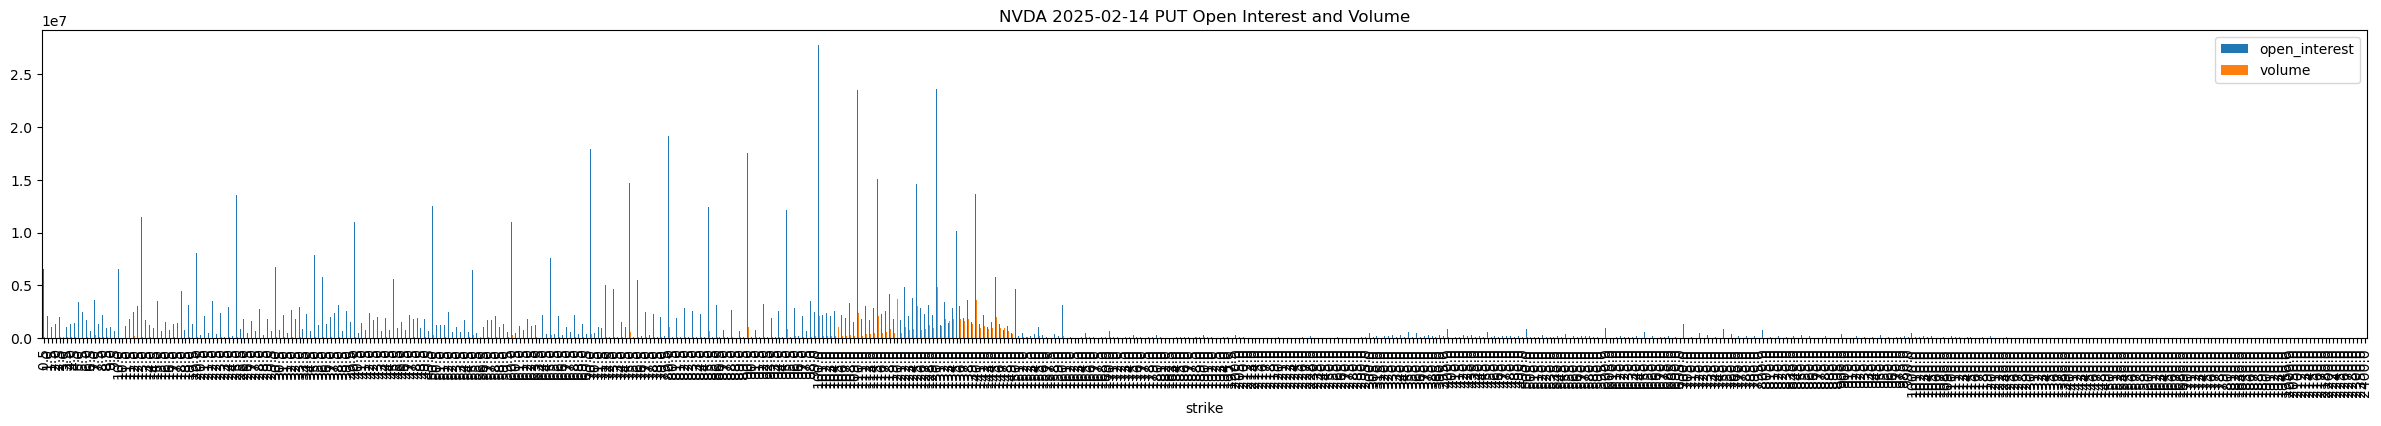

In [118]:
df_put = (
    df_symbol.loc[(df_symbol["option_type"] == "put")]
    .reset_index()
    .set_index("strike")
)
df_put = df_put[["open_interest", "volume"]].groupby(level=0).sum()
df_put[["open_interest", "volume"]].plot(
    kind="bar",
    figsize=(30, 4),
    title=f"{symbol} {latest_date} PUT Open Interest and Volume",
)
print (df_put["open_interest"].sum())
print(df_put["volume"].sum())

<Figure size 1000x600 with 0 Axes>

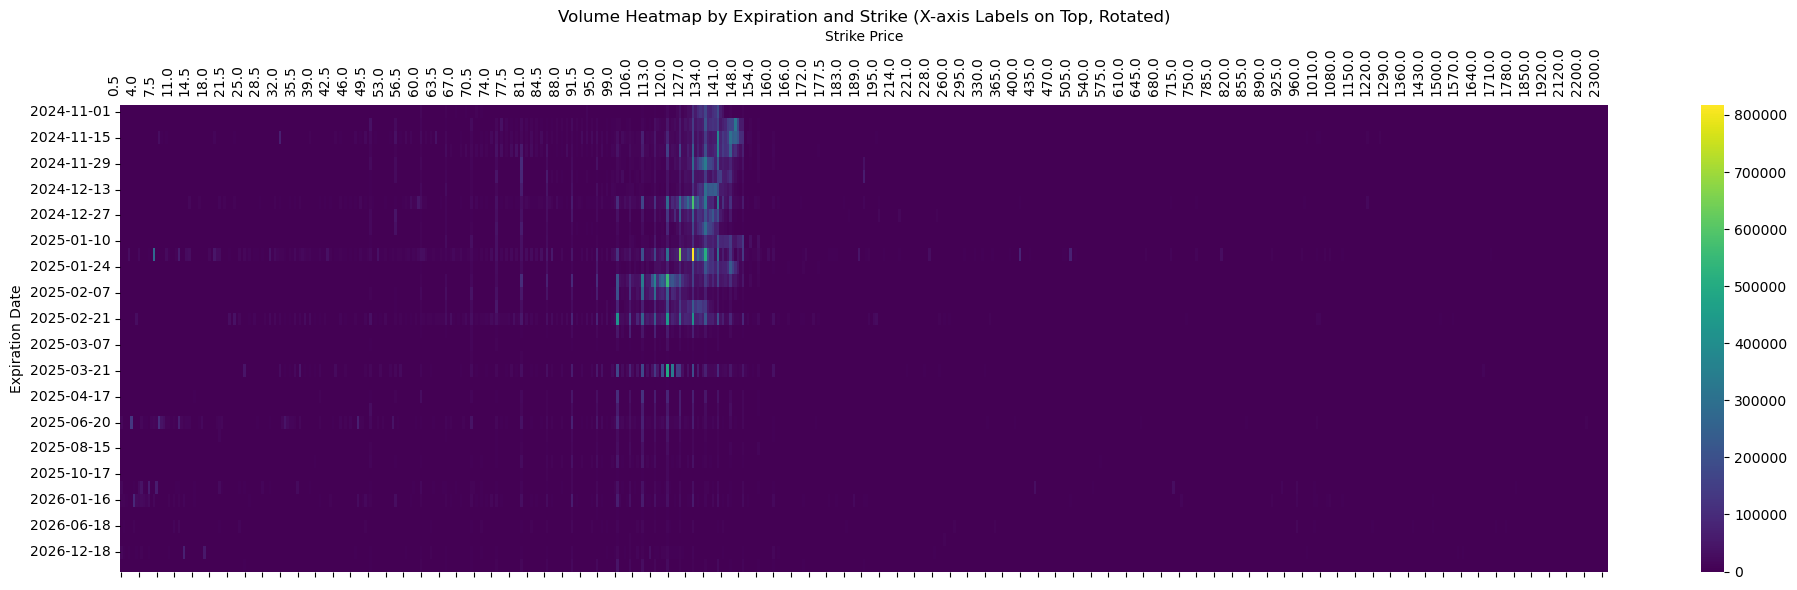

In [127]:
# Plotting the heatmap
df = df_symbol.loc[df_symbol["option_type"] == "put"][
    ["expiration", "strike", "volume", "open_interest"]
]
plt.figure(figsize=(10, 6))
heatmap_data = df.pivot_table(
    index="expiration", columns="strike", values="volume", aggfunc="sum"
).fillna(0)

# Plotting the heatmap without numbers
plt.figure(figsize=(20, 6))
ax = sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)

# Move x-axis labels to the top and rotate them
ax.tick_params(
    axis="x", which="both", labeltop=True, labelbottom=False
)  # Move labels to the top
plt.xticks(rotation=90, ha="right")  # Rotate labels and align them properly

# Optional: Move x-axis title to the top
ax.xaxis.set_label_position("top")
plt.xlabel("Strike Price")

# Customizing the plot
plt.title("Volume Heatmap by Expiration and Strike (X-axis Labels on Top, Rotated)")
plt.ylabel("Expiration Date")
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

<Axes: xlabel='strike'>

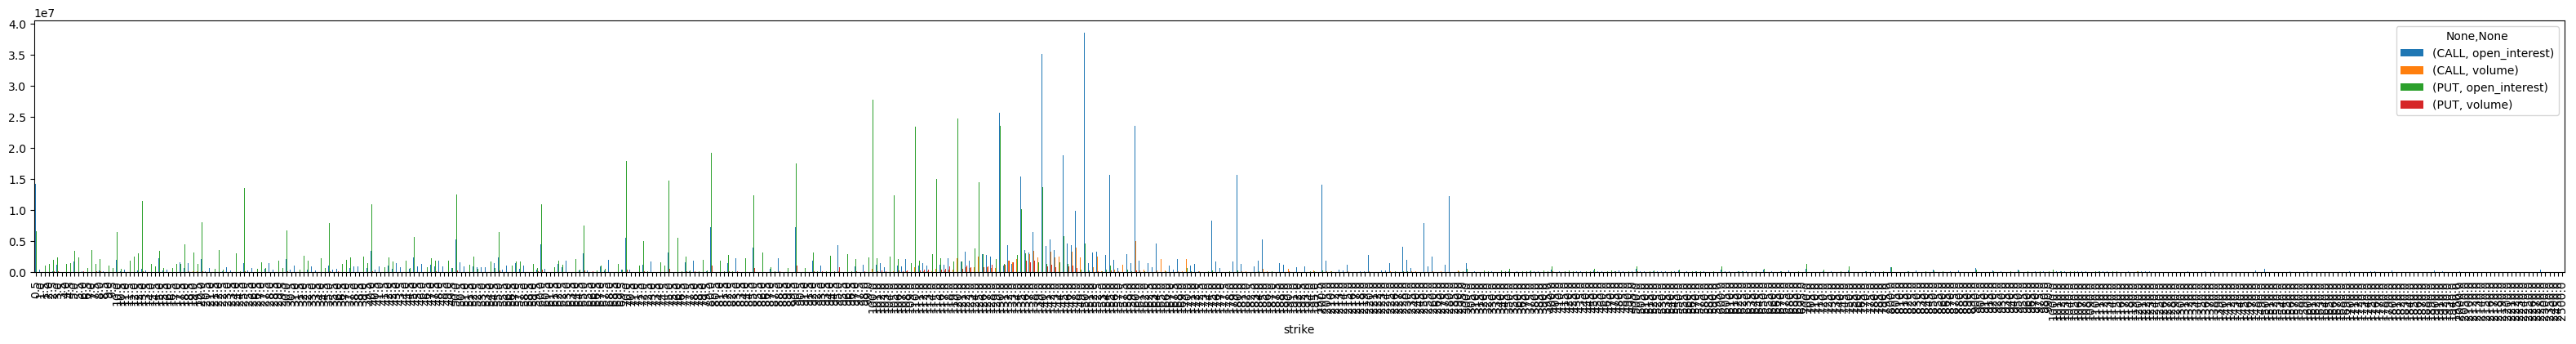

In [128]:
merged_df = pd.concat(
    [df_call[["open_interest", "volume"]], df_put[["open_interest", "volume"]]],
    axis=1,
    keys=["CALL", "PUT"],
)
merged_df.sort_index().plot(kind="bar", figsize=(40, 4))